# GTCRN + Wiener Filter (EXP3p2a) Analysis

This notebook reviews the GTCRNWF EXP3p2a experiments that append causal Wiener filtering to the GTCRN neural enhancer. We focus on how frame length (8/20/25 ms) and the Wiener strength parameter `mu` (intelligibility, balanced, quality settings) impact objective metrics across the DNS challenge test set.

## Experiment Catalogue
- **Noisy Baseline:** Raw noisy mixtures (no enhancement).
- **GTCRN (No WF):** Baseline neural enhancer without post-processing.
- **GTCRN+WF 8 ms:** `mu` tuned for intelligibility (0.123), balanced (0.552), and quality (0.980).
- **GTCRN+WF 20 ms:** Larger analysis window; `mu` values 0.374, 0.677, 0.980.
- **GTCRN+WF 25 ms:** Longest frame; `mu` values 0.374, 0.677, 0.980.
- Metrics tracked per SNR (`-5` to `15` dB): PESQ, STOI, SI-SDR, DNSMOS overall.

In [1]:
import warnings
from pathlib import Path
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Configure paths
repo_root = Path.cwd().parent.parent
results_root = repo_root / "results" / "EXP3" / "GTCRN"
figures_dir = repo_root / "reports" / "figures" / "GTCRNWF_EXP3p2a"
figures_dir.mkdir(parents=True, exist_ok=True)

snr_levels = [-5, 0, 5, 10, 15]
metrics_of_interest = ["PESQ", "STOI", "SI_SDR", "DNSMOS_mos_ovr"]

warnings.simplefilter("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.dpi": 300,
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

In [2]:
catalog = {
    "BASELINE_NOIZEUS_EARS": {
        "label": "Noisy Baseline",
        "frame_ms": None,
        "mu": None,
        "focus": "No Enhancement",
        "directory": repo_root / "results" / "BASELINE" / "NOIZEUS_EARS_BASELINE",
        "template": "BASELINE_NOIZEUS_EARS_[{snr}]dB.csv",
    },
    "GTCRN_EXP3p2a": {
        "label": "GTCRN (No WF)",
        "frame_ms": None,
        "mu": None,
        "focus": "Neural",
        "directory": results_root / "GTCRN_EXP3p2a",
        "template": "GTCRN_EXP3p2a_merged_[{snr}]dB.csv",
    },
    "GTCRNWF_EXP3p2a_8ms_intelligibility": {
        "label": "GTCRN+WF 8ms Intelligibility (mu=0.123)",
        "frame_ms": 8,
        "mu": 0.123,
        "focus": "Intelligibility",
        "directory": results_root / "GTCRNWF_EXP3p2a_8ms_intelligibility",
        "template": "GTCRNWF_EXP3p2a_8ms_intelligibility_merged_[{snr}]dB.csv",
    },
    "GTCRNWF_EXP3p2a_8ms_balance": {
        "label": "GTCRN+WF 8ms Balanced (mu=0.552)",
        "frame_ms": 8,
        "mu": 0.552,
        "focus": "Balanced",
        "directory": results_root / "GTCRNWF_EXP3p2a_8ms_balance",
        "template": "GTCRNWF_EXP3p2a_8ms_balance_merged_[{snr}]dB.csv",
    },
    "GTCRNWF_EXP3p2a_8ms_quality": {
        "label": "GTCRN+WF 8ms Quality (mu=0.980)",
        "frame_ms": 8,
        "mu": 0.98,
        "focus": "Quality",
        "directory": results_root / "GTCRNWF_EXP3p2a_8ms_quality",
        "template": "GTCRNWF_EXP3p2a_8ms_quality_merged_[{snr}]dB.csv",
    },
    "GTCRNWF_EXP3p2a_20ms_intelligibility": {
        "label": "GTCRN+WF 20ms Intelligibility (mu=0.374)",
        "frame_ms": 20,
        "mu": 0.374,
        "focus": "Intelligibility",
        "directory": results_root / "GTCRNWF_EXP3p2a_20ms_intelligibility",
        "template": "GTCRNWF_EXP3p2a_20ms_intelligibility_merged_[{snr}]dB.csv",
    },
    "GTCRNWF_EXP3p2a_20ms_balance": {
        "label": "GTCRN+WF 20ms Balanced (mu=0.677)",
        "frame_ms": 20,
        "mu": 0.677,
        "focus": "Balanced",
        "directory": results_root / "GTCRNWF_EXP3p2a_20ms_balance",
        "template": "GTCRNWF_EXP3p2a_20ms_balance_merged_[{snr}]dB.csv",
    },
    "GTCRNWF_EXP3p2a_20ms_quality": {
        "label": "GTCRN+WF 20ms Quality (mu=0.980)",
        "frame_ms": 20,
        "mu": 0.98,
        "focus": "Quality",
        "directory": results_root / "GTCRNWF_EXP3p2a_20ms_quality",
        "template": "GTCRNWF_EXP3p2a_20ms_quality_merged_[{snr}]dB.csv",
    },
    "GTCRNWF_EXP3p2a_25ms_intelligibility": {
        "label": "GTCRN+WF 25ms Intelligibility (mu=0.374)",
        "frame_ms": 25,
        "mu": 0.374,
        "focus": "Intelligibility",
        "directory": results_root / "GTCRNWF_EXP3p2a_25ms_intelligibility",
        "template": "GTCRNWF_EXP3p2a_25ms_intelligibility_merged_[{snr}]dB.csv",
    },
    "GTCRNWF_EXP3p2a_25ms_balance": {
        "label": "GTCRN+WF 25ms Balanced (mu=0.677)",
        "frame_ms": 25,
        "mu": 0.677,
        "focus": "Balanced",
        "directory": results_root / "GTCRNWF_EXP3p2a_25ms_balance",
        "template": "GTCRNWF_EXP3p2a_25ms_balance_merged_[{snr}]dB.csv",
    },
    "GTCRNWF_EXP3p2a_25ms_quality": {
        "label": "GTCRN+WF 25ms Quality (mu=0.980)",
        "frame_ms": 25,
        "mu": 0.98,
        "focus": "Quality",
        "directory": results_root / "GTCRNWF_EXP3p2a_25ms_quality",
        "template": "GTCRNWF_EXP3p2a_25ms_quality_merged_[{snr}]dB.csv",
    },
}

meta_fields = ["label", "frame_ms", "mu", "focus"]

In [3]:
def load_experiment(prefix: str, meta: dict) -> pd.DataFrame:
    """Load merged CSV files for a given experiment across all SNR levels."""
    frames = []
    directory = meta["directory"]
    template = meta["template"]
    for snr in snr_levels:
        csv_path = directory / template.format(snr=snr)
        df = pd.read_csv(csv_path)
        df['SNR'] = snr
        df['experiment'] = prefix
        frames.append(df)
    result = pd.concat(frames, ignore_index=True)
    if 'enhanced_file' in result.columns:
        result['noise_type'] = result['enhanced_file'].str.extract(r'NOIZEUS_NOISE_DATASET_(.*?)_SNR')
    else:
        result['noise_type'] = np.nan
    return result


def build_summary_tables() -> tuple[pd.DataFrame, pd.DataFrame]:
    """Return full concatenated data and SNR-aggregated summary tables."""
    all_frames = []
    summaries = []
    for exp_name, meta in catalog.items():
        df = load_experiment(exp_name, meta)
        for field in meta_fields:
            df[field] = meta.get(field)
        all_frames.append(df)

        summary = df.groupby('SNR')[metrics_of_interest].mean().reset_index()
        summary['experiment'] = exp_name
        for field in meta_fields:
            summary[field] = meta.get(field)
        summaries.append(summary)
    full_df = pd.concat(all_frames, ignore_index=True)
    summary_df = pd.concat(summaries, ignore_index=True)
    return full_df, summary_df


full_results, summary_by_snr = build_summary_tables()
summary_by_snr.head()

,SNR,PESQ,STOI,SI_SDR,DNSMOS_mos_ovr,experiment,label,frame_ms,mu,focus
0,-5,1.065751,0.586570,-4.989893,1.970603,BASELINE_NOIZEUS_EARS,Noisy Baseline,None,NaN,No Enhancement
1,0,1.093715,0.654918,-0.026259,2.263054,BASELINE_NOIZEUS_EARS,Noisy Baseline,None,NaN,No Enhancement
2,5,1.173282,0.715255,4.995548,2.436134,BASELINE_NOIZEUS_EARS,Noisy Baseline,None,NaN,No Enhancement
3,10,1.344649,0.773980,9.999116,2.638218,BASELINE_NOIZEUS_EARS,Noisy Baseline,None,NaN,No Enhancement
4,15,1.646841,0.813742,14.998889,2.748197,BASELINE_NOIZEUS_EARS,Noisy Baseline,None,NaN,No Enhancement


## Check Loaded Data
The next cell concatenates all metrics from the experiment CSVs and confirms the expected schema.

## Overall SNR-Averaged Performance
We compute the mean of each metric across all SNRs for each configuration to establish a high-level ranking.

In [4]:
meta_lookup = pd.DataFrame({
    key: {field: catalog[key].get(field) for field in meta_fields}
    for key in catalog
}).T

overall_mean = (
    summary_by_snr.groupby('experiment')[metrics_of_interest].mean()
    .join(meta_lookup)
    .reset_index()
    .rename(columns={'DNSMOS_mos_ovr': 'DNSMOS'})
)
overall_mean.sort_values('DNSMOS', ascending=False)

,experiment,PESQ,STOI,SI_SDR,DNSMOS,label,frame_ms,mu,focus
6,GTCRNWF_EXP3p2a_25ms_quality,1.667798,0.717897,10.159786,2.932191,GTCRN+WF 25ms Quality (mu=0.980),25,0.98,Quality
3,GTCRNWF_EXP3p2a_20ms_quality,1.662279,0.717611,10.196736,2.880909,GTCRN+WF 20ms Quality (mu=0.980),20,0.98,Quality
4,GTCRNWF_EXP3p2a_25ms_balance,1.715398,0.728316,10.655391,2.874323,GTCRN+WF 25ms Balanced (mu=0.677),25,0.677,Balanced
2,GTCRNWF_EXP3p2a_20ms_intelligibility,1.717619,0.728605,10.812553,2.874318,GTCRN+WF 20ms Intelligibility (mu=0.374),20,0.374,Intelligibility
5,GTCRNWF_EXP3p2a_25ms_intelligibility,1.719310,0.729083,10.797065,2.873883,GTCRN+WF 25ms Intelligibility (mu=0.374),25,0.374,Intelligibility
10,GTCRN_EXP3p2a,1.730299,0.730913,11.048315,2.867137,GTCRN (No WF),None,None,Neural
1,GTCRNWF_EXP3p2a_20ms_balance,1.713062,0.727942,10.655416,2.856279,GTCRN+WF 20ms Balanced (mu=0.677),20,0.677,Balanced
8,GTCRNWF_EXP3p2a_8ms_intelligibility,1.715897,0.728140,11.006450,2.853644,GTCRN+WF 8ms Intelligibility (mu=0.123),8,0.123,Intelligibility
7,GTCRNWF_EXP3p2a_8ms_balance,1.708615,0.726182,10.899626,2.839474,GTCRN+WF 8ms Balanced (mu=0.552),8,0.552,Balanced
9,GTCRNWF_EXP3p2a_8ms_quality,1.660099,0.719037,10.626459,2.773512,GTCRN+WF 8ms Quality (mu=0.980),8,0.98,Quality


## Percentage Gains vs Reference Systems
Tables below summarise the mean percentage change in each metric relative to (a) the noisy baseline mixtures and (b) the GTCRN output. Positive values mean the row configuration improves upon the reference.

In [5]:
def compute_percentage_gain(reference_key: str) -> pd.DataFrame:
    """Return mean percentage gain over a reference experiment for all metrics."""
    reference = summary_by_snr[summary_by_snr['experiment'] == reference_key]
    rows = []
    for exp_name in catalog:
        if exp_name == reference_key:
            continue
        exp_slice = summary_by_snr[summary_by_snr['experiment'] == exp_name]
        merged = exp_slice.merge(reference, on='SNR', suffixes=('', '_ref'))
        for metric in metrics_of_interest:
            delta = merged[metric] - merged[f"{metric}_ref"]
            pct = (delta / merged[f"{metric}_ref"]) * 100
            rows.append({
                'experiment': exp_name,
                'metric': metric,
                'avg_pct': pct.mean(),
            })
    pivot = pd.DataFrame(rows).pivot(index='experiment', columns='metric', values='avg_pct')
    pivot = pivot.rename(columns={'DNSMOS_mos_ovr': 'DNSMOS'})
    pivot = pivot.join(meta_lookup[['label']], how='left')
    pivot = pivot[['label', 'PESQ', 'STOI', 'SI_SDR', 'DNSMOS']]
    return pivot.sort_values('DNSMOS', ascending=False)

pct_vs_noise = compute_percentage_gain('BASELINE_NOIZEUS_EARS')
pct_vs_gtcrn = compute_percentage_gain('GTCRN_EXP3p2a')

display(pct_vs_noise)
display(pct_vs_gtcrn)

,label,PESQ,STOI,SI_SDR,DNSMOS
experiment,,,,,
GTCRNWF_EXP3p2a_25ms_quality,GTCRN+WF 25ms Quality (mu=0.980),30.798404,1.207209,-5585.807368,20.838304
GTCRNWF_EXP3p2a_20ms_quality,GTCRN+WF 20ms Quality (mu=0.980),30.403475,1.173466,-5593.522114,18.681116
GTCRNWF_EXP3p2a_20ms_intelligibility,GTCRN+WF 20ms Intelligibility (mu=0.374),34.675945,2.808993,-5789.560478,18.345589
GTCRNWF_EXP3p2a_25ms_intelligibility,GTCRN+WF 25ms Intelligibility (mu=0.374),34.818242,2.874813,-5782.581383,18.300055
GTCRNWF_EXP3p2a_25ms_balance,GTCRN+WF 25ms Balanced (mu=0.677),34.546777,2.763852,-5736.197755,18.260058
GTCRN_EXP3p2a,GTCRN (No WF),35.671775,3.151262,-5813.296753,18.053897
GTCRNWF_EXP3p2a_20ms_balance,GTCRN+WF 20ms Balanced (mu=0.677),34.360958,2.719133,-5710.683313,17.596954
GTCRNWF_EXP3p2a_8ms_intelligibility,GTCRN+WF 8ms Intelligibility (mu=0.123),34.559442,2.749286,-5811.282070,17.503976
GTCRNWF_EXP3p2a_8ms_balance,GTCRN+WF 8ms Balanced (mu=0.552),34.029956,2.463620,-5783.401222,16.927072


,label,PESQ,STOI,SI_SDR,DNSMOS
experiment,,,,,
GTCRNWF_EXP3p2a_25ms_quality,GTCRN+WF 25ms Quality (mu=0.980),-3.554113,-1.882486,-6.473756,2.412714
GTCRNWF_EXP3p2a_20ms_quality,GTCRN+WF 20ms Quality (mu=0.980),-3.833861,-1.915435,-6.238549,0.565499
GTCRNWF_EXP3p2a_20ms_intelligibility,GTCRN+WF 20ms Intelligibility (mu=0.374),-0.722443,-0.331484,-1.520864,0.249591
GTCRNWF_EXP3p2a_25ms_intelligibility,GTCRN+WF 25ms Intelligibility (mu=0.374),-0.612486,-0.267380,-1.658789,0.199918
GTCRNWF_EXP3p2a_25ms_balance,GTCRN+WF 25ms Balanced (mu=0.677),-0.811170,-0.375121,-2.812580,0.135715
GTCRNWF_EXP3p2a_20ms_balance,GTCRN+WF 20ms Balanced (mu=0.677),-0.945215,-0.418753,-2.822368,-0.389200
GTCRNWF_EXP3p2a_8ms_intelligibility,GTCRN+WF 8ms Intelligibility (mu=0.123),-0.807600,-0.389500,-0.213232,-0.462886
GTCRNWF_EXP3p2a_8ms_balance,GTCRN+WF 8ms Balanced (mu=0.552),-1.180693,-0.666110,-1.043284,-0.943931
GTCRNWF_EXP3p2a_8ms_quality,GTCRN+WF 8ms Quality (mu=0.980),-3.890463,-1.670591,-3.176415,-3.066221


## Best Configuration per Metric and SNR
Identifies which setup delivers the highest score for each metric at each SNR level.

In [6]:
best_records = []
for snr in snr_levels:
    subset = summary_by_snr[summary_by_snr['SNR'] == snr]
    for metric in metrics_of_interest:
        idx = subset[metric].idxmax()
        row = subset.loc[idx]
        best_records.append({
            'SNR': snr,
            'Metric': metric,
            'Best Config': row['label'],
            'Score': row[metric],
        })
best_table = pd.DataFrame(best_records)
best_table

,SNR,Metric,Best Config,Score
0,-5,PESQ,GTCRN (No WF),1.237243
1,-5,STOI,GTCRN (No WF),0.605330
2,-5,SI_SDR,GTCRN+WF 8ms Intelligibility (mu=0.123),4.168799
3,-5,DNSMOS_mos_ovr,GTCRN+WF 25ms Quality (mu=0.980),2.182129
4,0,PESQ,GTCRN (No WF),1.444525
5,0,STOI,GTCRN (No WF),0.677242
6,0,SI_SDR,GTCRN (No WF),7.607530
7,0,DNSMOS_mos_ovr,GTCRN+WF 25ms Quality (mu=0.980),2.620732
8,5,PESQ,GTCRN (No WF),1.658661
9,5,STOI,GTCRN (No WF),0.747143


## Metric Trends vs SNR
Visualize how GTCRN compares against the Wiener variants across SNR for each objective metric.

WindowsPath('c:/Users/kapun_63wn2un/Documents/ELEN4012 - Investigation/Repository/PROJECT-25P85/reports/figures/GTCRNWF_EXP3p2a/gtcrnwf_metric_trends.png')

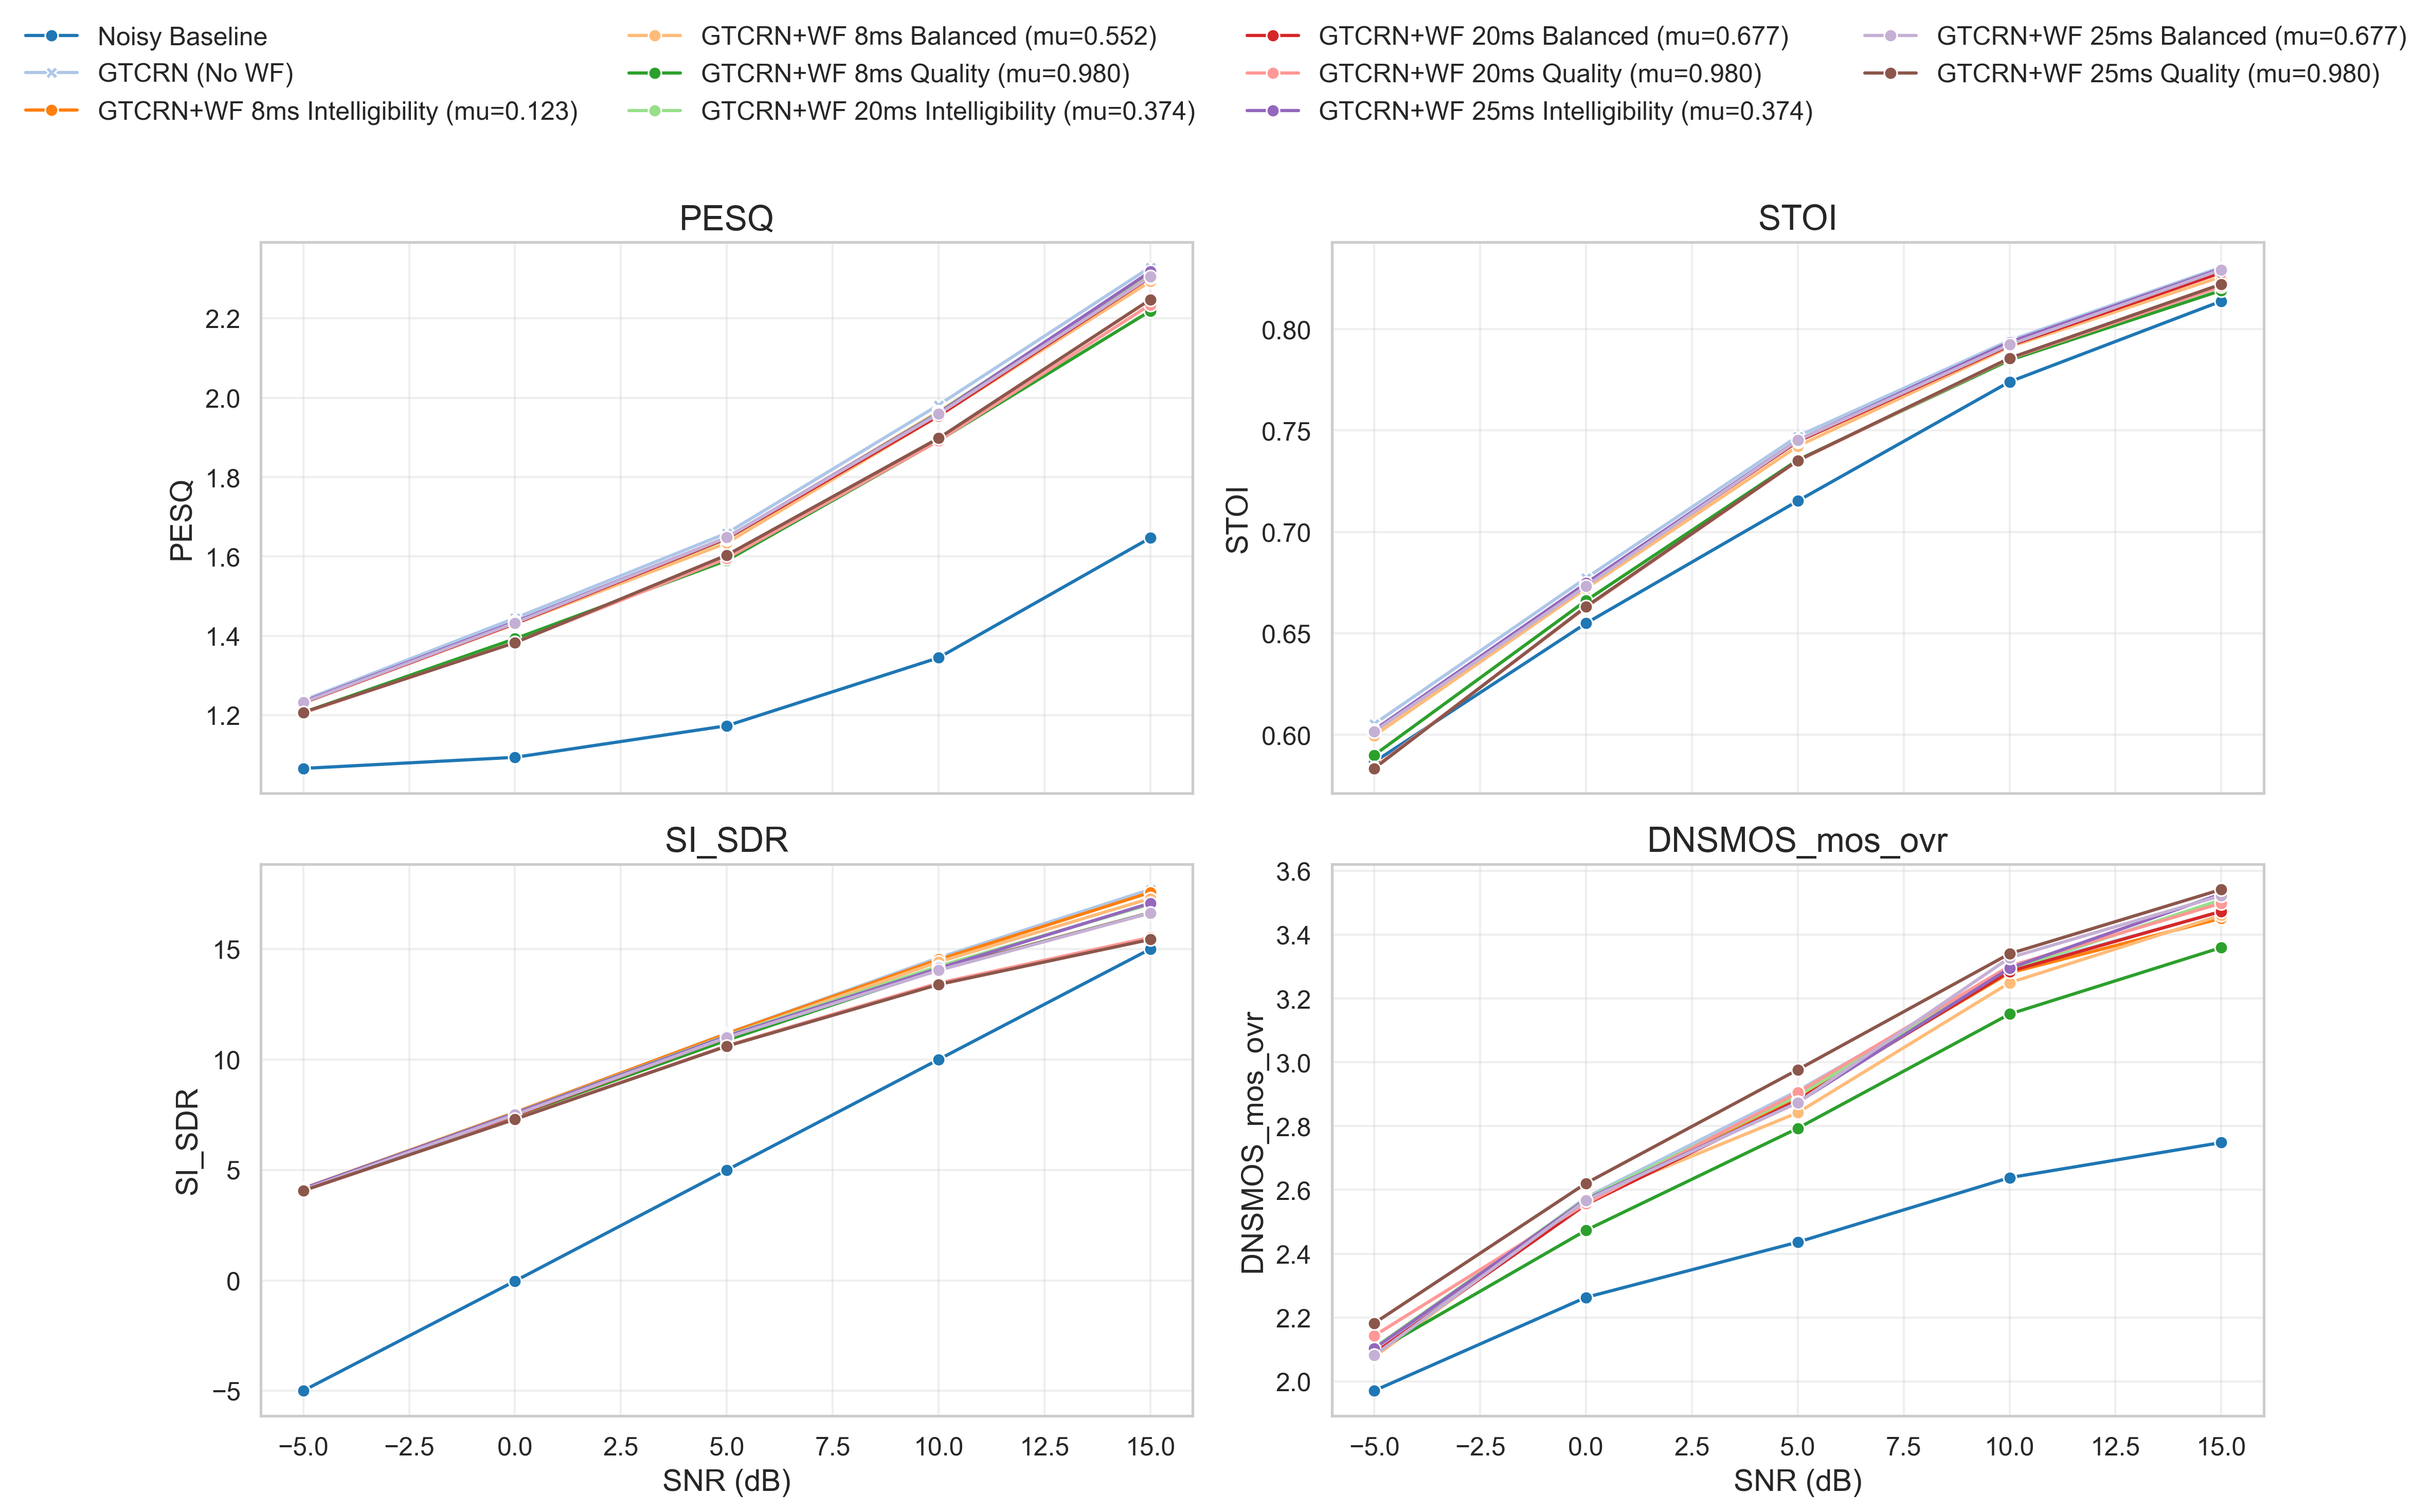

In [7]:
palette = sns.color_palette("tab20", len(catalog))
label_order = [catalog[key]['label'] for key in catalog]
label_map = {key: meta['label'] for key, meta in catalog.items()}
marker_map = {label: ('X' if label == 'GTCRN (No WF)' else 'o') for label in label_order}
plot_df = summary_by_snr.copy()
plot_df['label'] = plot_df['experiment'].map(label_map)

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for idx, metric in enumerate(metrics_of_interest):
    ax = axes[idx]
    sns.lineplot(
        data=plot_df,
        x='SNR',
        y=metric,
        hue='label',
        style='label',
        markers=marker_map,
        dashes=False,
        palette=palette,
        hue_order=label_order,
        style_order=label_order,
        ax=ax,
    )
    ax.set_title(metric)
    ax.set_xlabel('SNR (dB)')
    ax.legend().remove()
    ax.grid(True, alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
fig.tight_layout(rect=[0, 0, 1, 0.88])
fig.legend(
    handles,
    labels,
    loc='upper center',
    ncol=4,
    frameon=False,
    bbox_to_anchor=(0.5, 0.99),
)
plot_path = figures_dir / "gtcrnwf_metric_trends.png"
fig.savefig(plot_path, bbox_inches='tight')
plot_path